# Priority Places Index

## Index domains and indices:

The focus is on identifying the places most at need, following discussions with Which? using this concept as a focus and to avoid too much variable multicollinearity

Format:
- Domain:
    - Indices

Priority Places Index:
- Proximity to and density of grocery retail facilities
    - Distance to the nearest largest store (km) (proximity)
    - Count of stores within 1km (density)
- Transport to and accessibility of grocery retail facilities
    - Average travel distance (km) (SIM)
    - Acessibility via public transport (2017-2020)   
- E-commerce access? *

- Proximity to and density of Non-supermarket food provision
    - Ethnic food stores and or convenience stores
        - Distance to nearest store (km)
        - Count of stores within 1km  
    - Market access:
        - Distance to nearest market (km)
        - Count of markets within 1km  
    - <span style="color:red"> Excluded dual inclusion of foodbanks for which as foodbank not viewed as a tenable solution for food insecurity </span>    
- Neighbourhood socio-economic and demographic
    - Proportion of population wexperiencing income deprivation (2011)
    - Proportion of population with no car access (2011)
    - Proportion of population who are pensioners (2011)
- Food for Families
    - Free school meal uptake (if data not available eligibiltiy)
    - Healthy start voucher usage
    - Food banks:
        - Distance to nearest foodbank (km)
        - Count of foodbanks within 1km ***       
- Fuel poverty pressures
    - Proportion of household in fuel poverty (2017-20)
    - Prepayment meter prevalence 
- Low cost grocery retail food provision **
    - Number of retailers within 1 km providing budget line 
    - Distance to nearest retailer providing budget line
    - <span style="color:red"> Discussion of some sort of moderation of these values based on the quality of offering (e.g. cost saving and breadth of useful products- how we'd qunaitify this might be based on general conesus/inhouse ranking of supermarket provision) </span>    


\* Discussion around including this in the index or as a way to toggle/ identify whether instore vs. online budget lines would be most useful (online shopping not regularly use by most deprived but could be used to budget by struggling families). 

** Whilst Which? seem sure we will get this data we are sceptical - only domain not relying on open data 

\*** Might be worth doing some sensitivity testing, want to capture areas with high density/demand but not over too large a geography ( considering ability to travel to the food bank), however 1 km might be too small a spatial scale?


# Set-up
## Install required packages

In [3]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Polygon, LineString, Point, shape
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp

## Set data directory

In [4]:
data_directory = '../../../Data/PriorityPlacesData/'

## Read in data

In [5]:
df = pd.read_csv(data_directory + 'infuse_lsoa_lyr_2011/infuse_lsoa_lyr_2011.csv')

# LSOA level
#lsoa_centroids = pd.read_csv(data_directory + 'Lower_layer_Super_Output_Areas_(December_2011)_Population_Weighted_Centroids_WGS.csv')

# efdi merging
efdi = pd.read_csv(data_directory + 'EFDI_IndividualVariables.csv')
df = df.merge(efdi, left_on='geo_code', right_on='id', how='left', indicator=True)
df.rename({'_merge': 'efdi_merge', 'Propn':'pensioners'}, inplace=True, axis=1)

# fuel poverty merging
fuel_poverty = pd.read_csv(data_directory + 'fuel_poverty.csv')
df = df.merge(fuel_poverty, left_on='geo_code', right_on='lsoa11cd', how='left', indicator=True)
df.rename({'_merge':'fuel_merge', 'Percent of households in fuel poverty':'fuel_poverty_pct'}, inplace=True, axis=1)

# other retailers distance
other_retailers_distance = pd.read_csv(data_directory + 'lsoa_non-supermarket_dist.csv')
df = df.merge(other_retailers_distance, left_on='geo_code', right_on='lsoa11cd', how='left', indicator=True)
df.rename({'_merge': 'other_retailers_distance_merge', '0': 'other_retailers_distance'}, inplace=True, axis=1)

# other retailers 1km count
other_retailers_1km_count = pd.read_csv(data_directory + 'lsoa_non-supermarket_1km_count.csv')
df = df.merge(other_retailers_1km_count, left_on='geo_code', right_on='lsoa11cd', how='left', indicator=True)
df.rename({'_merge': 'other_retailers_1km_count_merge', 'FHRSID':'other_retailers_1km_count'}, inplace=True, axis=1)

# prepayment_meters merging
prepayment_meters = pd.read_csv(data_directory + 'Prepayment_meter_2017_with_household_count.csv')
df = df.merge(prepayment_meters, left_on='geo_code', right_on='Lower Layer Super Output Area (LSOA) Code', how='left', indicator=True)
df.rename({'_merge': 'prepayment_merge'}, inplace=True, axis=1)
df['prepayment_prevalence'] = df['Total meters'] / df['Occupied_Households']

# postcode level lookup
postcode_centroids = pd.read_csv(data_directory + 'ONS_Postcode_Directory_(Latest)_Centroids.csv')
df = df.merge(postcode_centroids.groupby('lsoa11')['oslaua'].first(), left_on='geo_code', right_on='lsoa11', how='left', indicator=True)
df.rename({'_merge': 'postcode_lad_merge'}, inplace=True, axis=1)

# Impute prepayment prevalence
lad_prepayment_median = df[['geo_code', 'oslaua', 'prepayment_prevalence']].groupby('oslaua')['prepayment_prevalence'].median()
df = df.merge(lad_prepayment_median, left_on='oslaua', right_index=True, how='inner', suffixes=('', '_imputed'))

# Food bank distance merging
foodbank_distance = pd.read_csv(data_directory + 'postcode_to_nearest_foodbank_distance.csv')
foodbank_distance = foodbank_distance.merge(postcode_centroids[['pcd', 'lsoa11']], left_on='pcd', right_on='pcd', how='left', indicator=True)
foodbank_distance = foodbank_distance.groupby('lsoa11')['0'].mean()
df = df.merge(foodbank_distance, left_on='geo_code', right_index=True, how='left', indicator=True)
df.rename({'_merge': 'foodbank_distance_merge', '0': 'foodbank_distance'}, inplace=True, axis=1)

# foodbank_1km_count
foodbank_1km_count = pd.read_csv(data_directory + 'postcode_foodbank_1km_count.csv')
foodbank_1km_count = foodbank_1km_count.merge(postcode_centroids[['pcd', 'lsoa11']], left_on='pcd', right_on='pcd', how='left', indicator=True)
foodbank_1km_count = foodbank_1km_count.groupby('lsoa11')['overlap_count'].mean()
df = df.merge(foodbank_1km_count, left_on='geo_code', right_index=True, how='left', indicator=True)
df.rename({'_merge': 'foodbank_1km_count_merge', 'overlap_count': 'foodbank_1km_count'}, inplace=True, axis=1)

#market_distance
market_distance = pd.read_csv(data_directory + 'postcode_to_nearest_market_distances.csv')
market_distance = market_distance.merge(postcode_centroids[['pcd', 'lsoa11']], left_on='pcd', right_on='pcd', how='left', indicator=True)
market_distance = market_distance.groupby('lsoa11')['0'].mean()
market_distance = market_distance.reset_index()
market_distance = market_distance[~market_distance['lsoa11'].str[0].isin(['9', 'S'])]
df = df.merge(market_distance, left_on='geo_code', right_on='lsoa11', how='left', indicator=True)
df.rename({'_merge': 'market_distance_merge', '0': 'market_distance'}, inplace=True, axis=1)

market_1km_count = pd.read_csv(data_directory + 'postcode_market_1km_count.csv')
market_1km_count = market_1km_count.merge(postcode_centroids[['pcd', 'lsoa11']], left_on='pcd', right_on='pcd', how='left', indicator=True)
market_1km_count = market_1km_count.groupby('lsoa11')['overlap_count'].mean()
market_1km_count = market_1km_count.reset_index()
market_1km_count = market_1km_count[~market_1km_count['lsoa11'].str[0].isin(['9', 'S'])]
df = df.merge(market_1km_count, left_on='geo_code', right_on='lsoa11', how='left', indicator=True)
df.rename({'_merge': 'market_1km_count_merge', 'overlap_count': 'market_1km_count'}, inplace=True, axis=1)


# healthy start voucher uptake
hsv = pd.read_csv(data_directory + 'healthy_start_voucher_uptake.csv')
hsv = hsv[~hsv['Uptake (%)'].isna()][['lsoa11cd', 'Uptake (%)']]
df = df.merge(hsv, left_on='geo_code', right_on='lsoa11cd', how='left', indicator=True)
df.rename({'_merge': 'hsv_merge', 'Uptake (%)': 'healthy_start_voucher_uptake'}, inplace=True, axis=1)

# free school meals
fsm = pd.read_csv(data_directory + 'Free_school_meals.csv')
df = df.merge(fsm, left_on='geo_code', right_on='lsoa11cd', how='left', indicator=True)
df.rename({'_merge': 'fsm_merge'}, inplace=True, axis=1)

# NI supermarket distance
NI_supermarket_distance = pd.read_csv(data_directory + 'NI_postcode_to_nearest_large_supermarket_distance.csv')
NI_supermarket_distance.rename({'0':'NI_nearest_lstore'}, axis=1, inplace=True)
NI_supermarket_distance = NI_supermarket_distance.merge(postcode_centroids[['pcd', 'lsoa11']], left_on='pcd', right_on='pcd', how='left', indicator=True)
NI_supermarket_distance = NI_supermarket_distance.groupby('lsoa11')['NI_nearest_lstore'].mean()
df = df.merge(NI_supermarket_distance, how='left', left_on='geo_code', right_on='lsoa11')
df['nearest lstore'] = df['nearest lstore'].fillna(df['NI_nearest_lstore'])

# NI supermarket count
NI_supermarket_count = pd.read_csv(data_directory + 'NI_postcode_to_nearest_large_supermarket_1km_count.csv')
NI_supermarket_count.rename({'overlap_count':'NI_stores1km'}, axis=1, inplace=True)
NI_supermarket_count = NI_supermarket_count.merge(postcode_centroids[['pcd', 'lsoa11']], left_on='pcd', right_on='pcd', how='left', indicator=True)
NI_supermarket_count = NI_supermarket_count.groupby('lsoa11')['NI_stores1km'].mean()
df = df.merge(NI_supermarket_count, how='left', left_on='geo_code', right_on='lsoa11')
df['stores1km'] = df['stores1km'].fillna(df['NI_stores1km'])

# NI income dep 
NI_income = pd.read_csv(data_directory + 'NIMDM17_SOA_income.csv')
NI_income = NI_income.drop(['Unnamed: 6', 'Unnamed: 7'], axis=1)
NI_income = NI_income.dropna()
NI_income['NI_income_dep'] = pd.to_numeric(NI_income['Proportion of the population living in households whose equivalised income is below 60 per cent of the NI median \n(%)'].str.replace('%', '')) / 100.0
df = df.merge(NI_income[['SOA2001', 'NI_income_dep']], how='left', left_on='geo_code', right_on='SOA2001')
df['income deprivation'] = df['income deprivation'].fillna(df['NI_income_dep'])

# NI car access
car_access = pd.read_csv(data_directory + 'UK_car_access_2011census.csv', skiprows=7)
car_access = car_access[~car_access.Area.isna()]
car_access['geography_type'] = car_access['Area'].str.split(':').apply(lambda x: x[0])
car_access['geo_code'] = car_access['Area'].str.split(':').apply(lambda x: x[1]).str.replace(' ', '')
car_access['proportion no car'] = car_access['No cars or vans in household']/ pd.to_numeric(car_access['All categories: Car or van availability'])
df = df.merge(car_access[['geo_code', 'proportion no car']], how='left', left_on='geo_code', right_on='geo_code')

# NI FSM
ni_fsm = pd.read_csv(data_directory + 'NI_FSM_cleaned.csv')
df = df.merge(ni_fsm[['LSOA11CD', 'prop fsme']], how='left', left_on='geo_code', right_on='LSOA11CD')
df['fsm_eligible_percent'] = df['fsm_eligible_percent'].fillna(df['prop fsme'])

/var/folders/zv/qv9ljngx5b90mpvpyh0pdsdh0000gn/T/ipykernel_948/932718475.py:33: DtypeWarning: Columns (32,42,47) have mixed types. Specify dtype option on import or set low_memory=False.
  postcode_centroids = pd.read_csv(data_directory + 'ONS_Postcode_Directory_(Latest)_Centroids.csv')
/var/folders/zv/qv9ljngx5b90mpvpyh0pdsdh0000gn/T/ipykernel_948/932718475.py:76: FutureWarning: Passing 'suffixes' which cause duplicate columns {'lsoa11cd_x'} in the result is deprecated and will raise a MergeError in a future version.
  df = df.merge(hsv, left_on='geo_code', right_on='lsoa11cd', how='left', indicator=True)


In [6]:
df['oslaua'].str[0].value_counts()

E    32847
S     6976
W     1909
N      890
Name: oslaua, dtype: int64

In [8]:
indicator_cols = [
    # Proximity to and density of retail facilities
    'stores1km', 
    'nearest lstore', 
    
    # Transport to and accessibility of grocery retail facilities
    'pt-retail', 
    'Average trip distance', 
    
    # E-commerce access
    'zshoponline', 
    'totaldeliv', 
    
    # Neighbourhood socio-economic and demographic
    'proportion no car', 
    'income deprivation', 
    
    # Proximity to and density of non-supermarket food provision
    'other_retailers_distance',
    'other_retailers_1km_count',
    'market_1km_count', 
    'market_distance', 
    
    # Food for families
    'fsm_eligible_percent',
    'healthy_start_voucher_uptake', 
    'foodbank_distance', 
    
    #Fuel poverty pressures
    'fuel_poverty_pct',
    'prepayment_prevalence_imputed']


priority_places = df[['geo_code'] + indicator_cols].copy()

In [9]:
priority_places = priority_places.drop_duplicates()

In [10]:
priority_places.geo_code.str[0].value_counts()

E    32844
S     6976
W     1909
9      890
Name: geo_code, dtype: int64

In [11]:
priority_places.isna().sum()

geo_code                            0
stores1km                           0
nearest lstore                      0
pt-retail                         890
Average trip distance             890
zshoponline                       890
totaldeliv                        890
proportion no car                   0
income deprivation                  0
other_retailers_distance            0
other_retailers_1km_count           0
market_1km_count                 7866
market_distance                  7866
fsm_eligible_percent                0
healthy_start_voucher_uptake     7867
foodbank_distance                   0
fuel_poverty_pct                  890
prepayment_prevalence_imputed     891
dtype: int64

In [12]:
# Drop NI
# priority_places = priority_places[~priority_places.geo_code.str[0].isin(['9'])]

In [13]:
# Drop Isles of Scilly
priority_places.drop(priority_places[priority_places['geo_code']=='E01019077'].index, inplace=True)

In [14]:
# Check for missing data
priority_places.isna().sum()

geo_code                            0
stores1km                           0
nearest lstore                      0
pt-retail                         890
Average trip distance             890
zshoponline                       890
totaldeliv                        890
proportion no car                   0
income deprivation                  0
other_retailers_distance            0
other_retailers_1km_count           0
market_1km_count                 7866
market_distance                  7866
fsm_eligible_percent                0
healthy_start_voucher_uptake     7866
foodbank_distance                   0
fuel_poverty_pct                  890
prepayment_prevalence_imputed     890
dtype: int64

In [15]:
# Now we have all the raw data, we can transform it into our index. 
# First set the geo_code as the index
priority_places.set_index('geo_code', inplace=True)

In [16]:
priority_places

,stores1km,nearest lstore,pt-retail,Average trip distance,zshoponline,totaldeliv,proportion no car,income deprivation,other_retailers_distance,other_retailers_1km_count,market_1km_count,market_distance,fsm_eligible_percent,healthy_start_voucher_uptake,foodbank_distance,fuel_poverty_pct,prepayment_prevalence_imputed
geo_code,,,,,,,,,,,,,,,,,
E01003513,2.0,0.639657,4.672484,15.724,0.901431,8.0,0.290323,0.111,164.033545,14.563636,0.0,2257.026969,24.895706,57.0,505.045992,7.69,0.266193
E01003630,0.0,1.212710,6.438685,15.322,-0.447984,8.0,0.642955,0.208,84.178396,61.750000,0.0,1179.836387,24.895706,57.0,1048.166786,17.75,0.266193
E01003617,11.0,0.328913,4.631219,15.341,1.412596,8.0,0.714415,0.140,82.569308,107.552632,1.0,270.219293,24.895706,57.0,478.268729,13.89,0.266193
E01003497,3.0,0.440224,7.049708,15.115,-0.447984,8.0,0.536977,0.198,324.724249,43.250000,0.0,2558.626998,24.895706,57.0,1665.415606,18.42,0.266193
E01003499,4.0,0.157703,2.977959,15.362,-1.585452,8.0,0.641531,0.247,105.516532,82.615385,0.0,1491.928565,24.895706,57.0,1795.847748,15.93,0.266193
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
S01012412,0.0,39.952801,40.476468,17.542,-0.135711,1.0,0.131673,0.040,2951.525396,0.312500,NaN,NaN,36.390977,NaN,42100.832558,30.90,0.199509
S01012413,0.0,49.108898,178.086625,36.554,-0.135711,1.0,0.150358,0.070,2201.602595,0.700000,NaN,NaN,36.390977,NaN,49518.067529,30.90,0.199509
S01012414,0.0,68.597603,190.000000,58.522,-0.341333,1.0,0.225806,0.080,2605.986386,0.392857,NaN,NaN,36.390977,NaN,68524.379731,30.90,0.199509


In [17]:
# The first task is to orient each indicator in the correct direction
# i.e. so that high values correspond to higher priority places
priority_places = pd.concat([1 * priority_places[[
                    'nearest lstore', 
                    'pt-retail', 
                    'Average trip distance', 
                    'proportion no car', 
                    'income deprivation', 
                    'market_distance', 
                    'fuel_poverty_pct', 
                    'prepayment_prevalence_imputed', 
                    'other_retailers_distance', 
                    'fsm_eligible_percent', 
                    'healthy_start_voucher_uptake']], 
                  -1 * priority_places[[
                      'foodbank_distance', 
                      'stores1km', 
                      'zshoponline', 
                      'totaldeliv', 
                      'market_1km_count', 
                      'other_retailers_1km_count']]], axis=1)



In [18]:
priority_places.columns

Index(['nearest lstore', 'pt-retail', 'Average trip distance',
       'proportion no car', 'income deprivation', 'market_distance',
       'fuel_poverty_pct', 'prepayment_prevalence_imputed',
       'other_retailers_distance', 'fsm_eligible_percent',
       'healthy_start_voucher_uptake', 'foodbank_distance', 'stores1km',
       'zshoponline', 'totaldeliv', 'market_1km_count',
       'other_retailers_1km_count'],
      dtype='object')

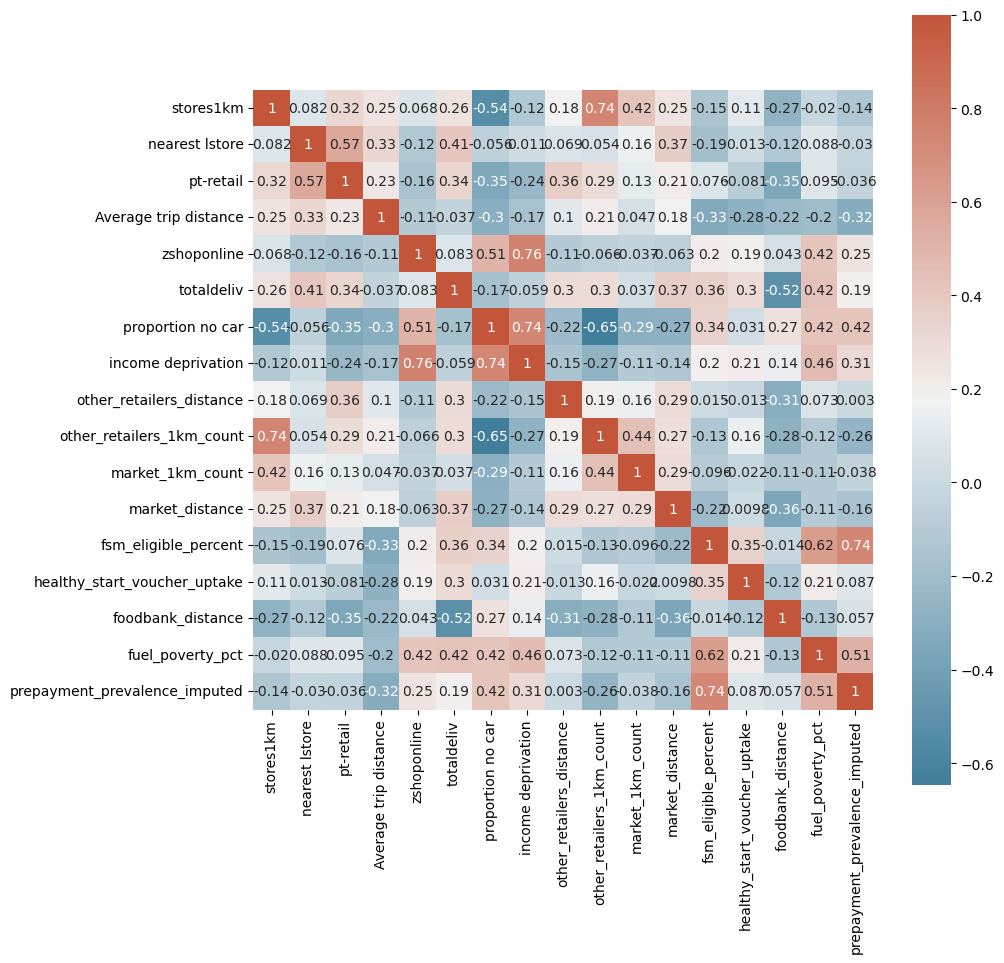

In [19]:
corr=priority_places[indicator_cols].corr()
cmap=sns.diverging_palette(230, 20, as_cmap=True)

f, ax = plt.subplots(figsize =(10,10))
sns.heatmap(corr,cmap=cmap,square=True, annot=True,ax=ax);

In [20]:
priority_places['country'] = priority_places.index.str[0]

In [21]:
country_counts = priority_places.reset_index().groupby('country')['geo_code'].count()

In [22]:
priority_places = priority_places.merge(country_counts, left_on='country', right_index=True, how='inner')

In [23]:
priority_places.rename({'geo_code': 'country_denominator'}, inplace=True, axis=1)

<AxesSubplot:>

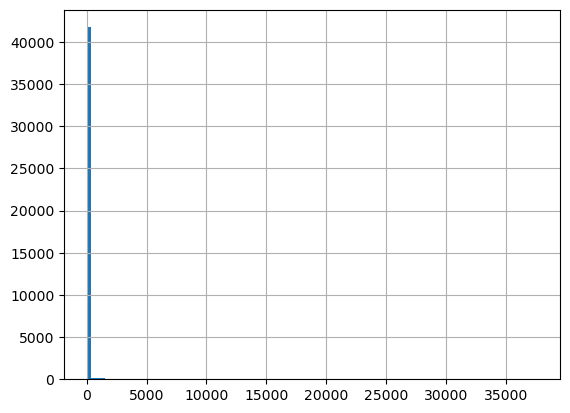

In [24]:
priority_places['nearest lstore'].hist(bins=100)

In [25]:
priority_places.fillna(0, inplace=True)

priority_places_ranked = priority_places.groupby('country').rank(method='min', ascending=False).astype(int)

for c in priority_places_ranked[indicator_cols].columns: 
    priority_places_ranked[c] = (priority_places_ranked[c] - 0.5) / priority_places['country_denominator']
    priority_places_ranked[c] = sp.stats.norm.ppf(priority_places_ranked[c],loc=0,scale=1)

In [26]:
priority_places_ranked['country'] = priority_places_ranked.index.str[0]

In [27]:
# Combine transformed indicators into domains

priority_places_ranked['domain_supermarket_proximity'] = 0.5 * priority_places_ranked[['nearest lstore', 'stores1km']].sum(axis=1)
priority_places_ranked['domain_supermarket_accessibility'] = 0.5 * priority_places_ranked[['pt-retail', 'Average trip distance']].sum(axis=1)
priority_places_ranked['domain_ecommerce_access'] = 0.5 * priority_places_ranked[['zshoponline', 'totaldeliv']].sum(axis=1)
priority_places_ranked['domain_socio_demographic'] = (1./2.) * priority_places_ranked[[ 'proportion no car', 'income deprivation']].sum(axis=1)
priority_places_ranked['domain_nonsupermarket_proximity'] = (1./4.) * priority_places_ranked[['other_retailers_distance','other_retailers_1km_count','market_1km_count', 'market_distance']].sum(axis=1)
priority_places_ranked['domain_food_for_families'] = (1./4.) * priority_places_ranked[['foodbank_distance', 'healthy_start_voucher_uptake', 'fsm_eligible_percent']].sum(axis=1)
priority_places_ranked['domain_fuel_poverty'] = 0.5 * priority_places_ranked[['fuel_poverty_pct','prepayment_prevalence_imputed']].sum(axis=1)

domain_columns = ['domain_supermarket_proximity', 
                  'domain_supermarket_accessibility', 
                  'domain_ecommerce_access', 
                  'domain_socio_demographic', 
                  'domain_nonsupermarket_proximity', 
                  'domain_food_for_families', 
                  'domain_fuel_poverty']

In [28]:
priority_places_ranked[priority_places_ranked['country']=='9']

,nearest lstore,pt-retail,Average trip distance,proportion no car,income deprivation,market_distance,fuel_poverty_pct,prepayment_prevalence_imputed,other_retailers_distance,fsm_eligible_percent,...,other_retailers_1km_count,country_denominator,country,domain_supermarket_proximity,domain_supermarket_transport,domain_ecommerce_access,domain_socio_demographic,domain_nonsupermarket_proximity,domain_food_for_families,domain_fuel_poverty
geo_code,,,,,,,,,,,,,,,,,,,,,
95YY06W1,-1.482519,-3.257598,-3.257598,-0.137025,0.581840,-3.257598,-3.257598,-3.257598,-1.324331,0.773332,...,-0.615534,1,9,-2.370058,-3.257598,-3.257598,0.222408,-2.113765,-0.355857,-3.257598
95PP15W1,-0.500314,-3.257598,-3.257598,0.750740,0.284008,-3.257598,-3.257598,-3.257598,-0.827656,0.773332,...,-0.880383,1,9,-1.878956,-3.257598,-3.257598,0.517374,-2.055809,-0.549331,-3.257598
95YY21W1,-1.508367,-3.257598,-3.257598,0.646466,-0.217152,-3.257598,-3.257598,-3.257598,-1.918433,0.773332,...,-1.017346,1,9,-2.382982,-3.257598,-3.257598,0.214657,-2.362744,-0.359536,-3.257598
95YY15S2,0.097320,-3.257598,-3.257598,-1.055906,-1.491025,-3.257598,-3.257598,-3.257598,1.022083,0.773332,...,0.134182,1,9,-1.580139,-3.257598,-3.257598,-1.273465,-1.339733,-0.826990,-3.257598
95PP03W1,-2.571963,-3.257598,-3.257598,0.228701,-1.739070,-3.257598,-3.257598,-3.257598,-2.931731,0.773332,...,-0.855752,1,9,-2.914781,-3.257598,-3.257598,-0.755184,-2.575670,-0.165705,-3.257598
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95EE10W1,-1.402808,-3.257598,-3.257598,0.506708,0.385320,-3.257598,-3.257598,-3.257598,-1.148986,-0.561939,...,-0.940052,1,9,-2.330203,-3.257598,-3.257598,0.446014,-2.151058,-0.736856,-3.257598
95JJ13S2,0.391395,-3.257598,-3.257598,1.065794,-0.108646,-3.257598,-3.257598,-3.257598,0.331258,-0.561939,...,-0.307547,1,9,0.397490,-3.257598,-3.257598,0.478574,-1.622871,-1.130648,-3.257598
95JJ10W1,-1.678454,-3.257598,-3.257598,0.086007,-1.410382,-3.257598,-3.257598,-3.257598,-0.728525,-0.561939,...,-0.788615,1,9,-2.468026,-3.257598,-3.257598,-0.662187,-2.008084,-0.652100,-3.257598


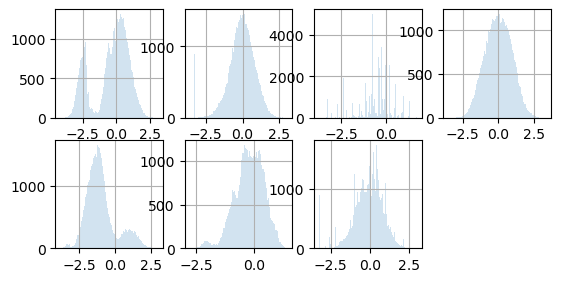

In [29]:
import matplotlib.pyplot as plt
count = 0
for domain in domain_columns:
    count += 1
    plt.subplot(3,4,count)
    priority_places_ranked[domain].hist(bins=100, alpha=0.2)

In [30]:
# Rank the domains
priority_places_domains = priority_places_ranked[domain_columns + ['country']].groupby('country').rank(method='min').astype(int)

In [31]:
priority_places_domains['country'] = priority_places_domains.index.str[0]

priority_places_domains = priority_places_domains.merge(country_counts, left_on='country', right_index=True, how='inner')
priority_places_domains.rename({'geo_code': 'country_denominator'}, inplace=True, axis=1)

In [61]:
priority_places_domains[(priority_places_domains['country']=='E') & (priority_places_domains['domain_socio_demographic']<20)]

,domain_supermarket_proximity,domain_supermarket_transport,domain_ecommerce_access,domain_socio_demographic,domain_nonsupermarket_proximity,domain_food_for_families,domain_fuel_poverty,country,country_denominator,combined
geo_code,,,,,,,,,,
E01005350,28128,20549,955,4,32423,12095,6042,E,32843,17837
E01012655,31859,19978,955,17,31199,5512,5051,E,32843,17631
E01007133,17850,17531,955,1,29867,2367,4427,E,32843,4201
E01007122,28605,22458,955,9,22165,3038,1927,E,32843,5240
E01006611,31544,31229,955,13,25214,6488,482,E,32843,18267
E01006677,15978,30251,955,15,25902,3917,618,E,32843,6586
E01013136,32000,32042,43,5,30005,407,4555,E,32843,23803
E01013137,32460,32630,43,8,32362,206,7863,E,32843,29500
E01013139,31605,32696,43,14,31607,116,2712,E,32843,26750


In [36]:
priority_places_domains_normalised = pd.DataFrame(columns=priority_places_domains[domain_columns].columns)
for c in priority_places_domains[domain_columns].columns:
    priority_places_domains_normalised[c] = -23 * np.log(1 - (priority_places_domains[c] / priority_places_domains['country_denominator']) * (1 - np.exp(- 100 / 23)))

priority_places_domains['combined'] = (1./8.) * priority_places_domains_normalised['domain_supermarket_proximity'] + \
(1./8.) * priority_places_domains_normalised['domain_supermarket_accessibility'] + \
(1./8.) * priority_places_domains_normalised['domain_ecommerce_access'] + \
(1./8.) * priority_places_domains_normalised['domain_nonsupermarket_proximity'] + \
(1./6.) * priority_places_domains_normalised['domain_socio_demographic'] + \
(1./6.) * priority_places_domains_normalised['domain_food_for_families'] + \
(1./6.) * priority_places_domains_normalised['domain_fuel_poverty']


In [37]:
priority_places_domains['country'].value_counts()

E    32843
S     6976
W     1909
9      890
Name: country, dtype: int64

In [40]:
priority_places_domains['combined'] = priority_places_domains[['country', 'combined']].groupby('country').rank(method='min').astype(int)

In [38]:
priority_places_domains[['country', 'combined']].groupby('country').rank(method='min').astype(int).to_csv(data_directory + 'priority_places_v1_2_combined_ranks.csv')

In [87]:
priority_places_deciles = priority_places_domains.copy()
for country in ['E', 'S', 'W', '9']:
    for col in domain_columns + ['combined']:
        if country == '9' and col in ['domain_ecommerce_access', 'domain_supermarket_accessibility', 'domain_fuel_poverty']:
            priority_places_deciles.loc[priority_places_deciles['country']==country, col] = 0
        else:
            priority_places_deciles.loc[priority_places_deciles['country']==country, col] = pd.to_numeric(pd.qcut(priority_places_domains.loc[priority_places_deciles['country']==country, col], 10, duplicates='drop', labels=range(1,11)))

In [80]:
priority_places_deciles[priority_places_deciles.index.str[0]=='9'].domain_food_for_families.value_counts()

10.0    89
8.0     89
5.0     89
4.0     89
9.0     89
6.0     89
3.0     89
7.0     89
2.0     89
1.0     89
Name: domain_food_for_families, dtype: int64

In [81]:
priority_places.loc['E01003499']

nearest lstore                      0.157703
pt-retail                           2.977959
Average trip distance                 15.362
proportion no car                   0.641531
income deprivation                     0.247
market_distance                  1491.928565
fuel_poverty_pct                       15.93
prepayment_prevalence_imputed       0.266193
other_retailers_distance          105.516532
fsm_eligible_percent               24.895706
healthy_start_voucher_uptake            57.0
foodbank_distance               -1795.847748
stores1km                               -4.0
zshoponline                         1.585452
totaldeliv                              -8.0
market_1km_count                        -0.0
other_retailers_1km_count         -82.615385
country                                    E
country_denominator                    32843
Name: E01003499, dtype: object

<AxesSubplot:>

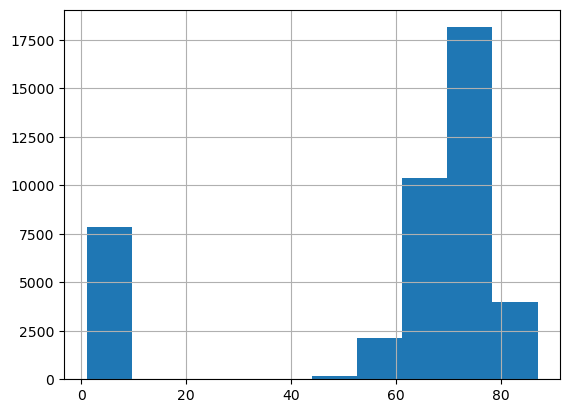

In [82]:
priority_places['healthy_start_voucher_uptake'].hist()

In [83]:
priority_places_deciles.loc['E01003499']

domain_supermarket_proximity        10.0
domain_supermarket_transport        10.0
domain_ecommerce_access              1.0
domain_socio_demographic             1.0
domain_nonsupermarket_proximity      9.0
domain_food_for_families             7.0
domain_fuel_poverty                  1.0
country                                E
country_denominator                32843
combined                             7.0
Name: E01003499, dtype: object

In [88]:
priority_places_deciles[domain_columns + ['combined']].to_csv(data_directory + 'priority_places_v1_2_decile_domains.csv')

In [42]:
priority_places_domains

,domain_supermarket_proximity,domain_supermarket_transport,domain_ecommerce_access,domain_socio_demographic,domain_nonsupermarket_proximity,domain_food_for_families,domain_fuel_poverty,country,country_denominator,combined
geo_code,,,,,,,,,,
E01003513,17288,26362,31036,13136,22591,12561,5176,E,32843,18902
E01003630,5641,22778,25682,2249,26814,16585,732,E,32843,9673
E01003617,31831,26966,32035,2223,32612,12337,1510,E,32843,30874
E01003497,23769,21828,25682,3993,21507,19402,652,E,32843,12708
E01003499,30792,30707,3041,1616,26627,19897,1041,E,32843,20860
...,...,...,...,...,...,...,...,...,...,...
S01012412,14,282,1400,5256,480,6961,1841,S,6976,4644
S01012413,7,9,1400,4553,676,6967,1841,S,6976,4321
S01012414,2,1,1269,3941,548,6976,1841,S,6976,4129


In [43]:
priority_places_domains.to_csv(data_directory + 'priority_places_domain_ranks_v1_2.csv')

In [52]:
priority_places_domains.country_denominator.value_counts()

32843    32843
6976      6976
1909      1909
890        890
Name: country_denominator, dtype: int64

In [55]:
priority_places_domains.shape

(42618, 10)